# Modeling Notebook One
This notebook contains the logic for performing Linear Regression, Ridge Regression, Random Forest Regression, and Random Forest Classification.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls 

In [ ]:
cleaned = pd.read_csv("/content/drive/Shareddrives/Data Science 303 Group Project/csv/cleaned_fires_data_with_four_closest_stations_nov21.csv")
cleaned = cleaned.replace([np.inf, -np.inf], np.nan)
cleaned = cleaned.dropna()

In [ ]:
display(cleaned.head())
display(cleaned.info(verbose=True))

STATION_LIST = ["BODIE", "BROOKS", "COHASSET", "EEL_RIVER", "HELL_HOLE", "HERNANDEZ"]
STATION_LIST += ["HUNTER_MOUNTAIN", "JUANITA_LAKE", "LADDER_BUTTE", "LAS_TABLAS", "LA_HONDA", "OAK_CREEK"]
STATION_LIST += ["PANAMINT", "PILOT_HILL", "SCORPION", "SOLDIER_MOUNTAIN", "SQUAW_LAKE", "STAMPEDE", "VAN_BREMMER", "WOLVERTON"]
STATION_LIST = set(STATION_LIST)

Final Part of Normalization: MinMax scaling latitude and longitude

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

lat = scaler.fit_transform(np.array(cleaned["LATITUDE"]).reshape(-1, 1))
long = scaler.fit_transform(np.array(cleaned["LONGITUDE"]).reshape(-1, 1))

# DROP ALL LATITUDE LONGITUDE COLUMNS, THEN READD THE SCALED LATITUDE AND LONGITUDE
drops = []
for col in cleaned.columns:
  if "LATITUDE" in col or "LONGITUDE" in col:
    drops.append(col)

for col in drops:
  del cleaned[col]

cleaned["S_LATITUDE"] = lat
cleaned["S_LONGITUDE"] = long


In [ ]:
# Elevation for the primary station is redundant. Drop all elevation columns from the primary station, except for one
elevation = cleaned["PRIMARY_STATION_1_MONTHS_PRIOR_ELEVATION"]

drops = []
for col in cleaned.columns:
  if "PRIMARY_STATION" in col and "ELEVATION" in col:
    drops.append(col)

for col in drops:
  del cleaned[col]

cleaned["PRIMARY_STATION_ELEVATION"] = elevation


In [ ]:
# We should have a large number of fires. If not, fail
print(len(cleaned))
assert(len(cleaned) > 70000)

In [ ]:
print( (1 - 360) % 365)

In [ ]:
cleaned['DURATION'] = (cleaned['CONT_DOY']-cleaned['DISCOVERY_DOY'])%365

In [ ]:
cleaned['DURATION'].max()

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

In [ ]:
# Working off of closest_station_1 for now, we can replicate later with other stations if we want
# 1. Get number of days that the fire was going (containment date - discovery date)
# Model 1a: fire duration

In [ ]:
numerical = cleaned.select_dtypes(include="number")
numerical.head()
numerical.info(verbose=True)

In [ ]:
cols = numerical.columns
closest = []

for col in cols:
  if (col[:16] == 'CLOSEST_STATION_' or col in STATION_LIST or col == "S_LATITUDE" or col == "S_LONGITUDE"): 
    closest.append(col)

In [ ]:
primary_station_data_cols = []
for col in cols:
  if ("PRIMARY_STATION" in col or col in STATION_LIST or col == "S_LATITUDE" or col == "S_LONGITUDE"): 
    primary_station_data_cols.append(col)

primary_station_df = pd.DataFrame()
for col in primary_station_data_cols:
  primary_station_df[col] = numerical[col]

primary_station_df["FIRE_SIZE"] = numerical["FIRE_SIZE"]
primary_station_df["DURATION"] = numerical["DURATION"]


In [ ]:
NUM_FEATURES_TO_KEEP = 300 + 2
correlation = primary_station_df.corr(method='pearson')
highest_correlation = (correlation.nlargest(NUM_FEATURES_TO_KEEP, 'FIRE_SIZE').index)
print(f"TOP {NUM_FEATURES_TO_KEEP} FEATURES WITH HIGHEST CORRELATION TO FIRE SIZE")
print(list(highest_correlation))

print(f"TOP 10 FEATURES WITH HIGHEST CORRELATION TO FIRE SIZE")
display(highest_correlation[2:12])
display(correlation.nlargest(NUM_FEATURES_TO_KEEP, 'FIRE_SIZE')[2:12]["FIRE_SIZE"]) 

fire_size_prediction_df = primary_station_df[highest_correlation]
del fire_size_prediction_df["FIRE_SIZE"]
del fire_size_prediction_df["DURATION"]

In [ ]:
display(fire_size_prediction_df)

In [ ]:
NUM_FEATURES_TO_KEEP = 300 + 2
correlation = primary_station_df.corr(method='pearson')
highest_correlation = (correlation.nlargest(NUM_FEATURES_TO_KEEP, 'DURATION').index)
print(f"TOP {NUM_FEATURES_TO_KEEP} FEATURES WITH HIGHEST CORRELATION TO FIRE DURATION")
display(highest_correlation) 

print(f"TOP 10 FEATURES WITH HIGHEST CORRELATION TO FIRE DURATION")
display(highest_correlation[2:12]) 
display(correlation.nlargest(NUM_FEATURES_TO_KEEP, 'DURATION')[2:12]["DURATION"])

fire_duration_prediction_df = primary_station_df[highest_correlation]
del fire_duration_prediction_df["FIRE_SIZE"]
del fire_duration_prediction_df["DURATION"]

In [ ]:
display(fire_duration_prediction_df)

In [ ]:
closest_df = pd.DataFrame()

for col in closest:
  closest_df[col] = numerical[col]

In [ ]:
closest_df.head()

# Model 1: Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score
from sklearn import svm
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor

# def log_transform(column):
#   """
#   Transforms a feature so that it is scaled logarithmically. Useful for correcting floating point errors
#   """
  

# def min_max_transform(column):
#   """
#   Transforms a feature using min-max scaling
#   """
#   pass

def run_full_linear_regression_with_accuracy(features, response, n_highest = 0):
  print(f"Response Minimum: {response.min()}")
  print(f"Response Maximum: {response.max()}")

  model = LinearRegression()  
  # Split into test and training set
  X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=2020)
  model.fit(X_train, y_train)

  training_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)
  print(f"Linear Regression Coefficients: { model.coef_ }\nLinear Regression Intercept: { model.intercept_}\n")

  print("Training: mean absolute error: ", mean_absolute_error(y_train, training_predictions))
  print("Test mean absolute error: ", mean_absolute_error(y_test, test_predictions))
  
  print("Training average error rate: ", median_absolute_error(y_train, training_predictions))
  print("Test average error rate: ", median_absolute_error(y_test, test_predictions))
  
  print("Explained variance in training set is: ", explained_variance_score(y_train, training_predictions))
  print("Explained variance in test set is: ", explained_variance_score(y_test, test_predictions))

  print("R2 Score training set: ", r2_score(y_train, training_predictions))
  print("R2 Score testing set: ", r2_score(y_test, test_predictions))

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Test Set")
  ax1.set_ylabel('Prediction from Test Set')
  ax1.set_title('True Value vs Predicted Value for Test Set: Linear Regression')
  ax1.scatter(y_test, test_predictions)
  plt.show()

  # Residual plot against predictor
  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("Test Set Prediction")
  ax1.set_ylabel('Residuals from Test Set')
  ax1.set_title('Residual Graph: Linear Regression')
  ax1.scatter(test_predictions, y_test - test_predictions)
  plt.show()



def run_full_ridge_regression_with_accuracy(features, response, n_highest = 0):
  print(f"Response Minimum: {response.min()}")
  print(f"Response Maximum: {response.max()}")

  
  model = Ridge()
  # Split into test and training set
  X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=2020)
  model.fit(X_train, y_train)

  training_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)
  print(f"Ridge Regression Coefficients: { model.coef_ }\Ridge Regression Intercept: { model.intercept_}\n")

  print("Training: mean absolute error: ", mean_absolute_error(y_train, training_predictions))
  print("Test mean absolute error: ", mean_absolute_error(y_test, test_predictions))
  
  print("Training average error rate: ", median_absolute_error(y_train, training_predictions))
  print("Test average error rate: ", median_absolute_error(y_test, test_predictions))
  
  print("Explained variance in training set is: ", explained_variance_score(y_train, training_predictions))
  print("Explained variance in test set is: ", explained_variance_score(y_test, test_predictions))

  print("R2 Score training set: ", r2_score(y_train, training_predictions))
  print("R2 Score testing set: ", r2_score(y_test, test_predictions))

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Test Set")
  ax1.set_ylabel('Prediction from Test Set')
  ax1.set_title('True Value vs Predicted Value for Test Set: Ridge Regression')
  ax1.scatter(y_test, test_predictions)
  plt.show()

  # Residual plot against predictor
  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("Test Set Prediction")
  ax1.set_ylabel('Residuals from Test Set')
  ax1.set_title('Residual Graph: Ridge Regression')
  ax1.scatter(test_predictions, y_test - test_predictions)
  plt.show()

def run_full_SVM_regression_with_accuracy(features, response, n_highest = 0):
  print(f"Response Minimum: {response.min()}")
  print(f"Response Maximum: {response.max()}")

  
  model = svm.SVR()
  # Split into test and training set
  X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=2020)
  model.fit(X_train, y_train)

  training_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)

  print("Training: mean absolute error: ", mean_absolute_error(y_train, training_predictions))
  print("Test mean absolute error: ", mean_absolute_error(y_test, test_predictions))
  
  print("Training average error rate: ", median_absolute_error(y_train, training_predictions))
  print("Test average error rate: ", median_absolute_error(y_test, test_predictions))
  
  print("Explained variance in training set is: ", explained_variance_score(y_train, training_predictions))
  print("Explained variance in test set is: ", explained_variance_score(y_test, test_predictions))

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Test Set")
  ax1.set_ylabel('Prediction from Test Set')
  ax1.set_title('True Value vs Predicted Value for Test Set: SVM Regression')
  ax1.scatter(y_test, test_predictions)
  plt.show()

  # Residual plot against predictor
  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("Test Set Prediction")
  ax1.set_ylabel('Residuals from Test Set')
  ax1.set_title('Residual Graph: SVM Regression')
  ax1.scatter(test_predictions, y_test - test_predictions)
  plt.show()

def run_full_random_forest_regression_with_accuracy(features, response, n_highest = 0):
  print(f"Response Minimum: {response.min()}")
  print(f"Response Maximum: {response.max()}")

  
  model = RandomForestRegressor(n_estimators=100)
  # Split into test and training set
  X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=2020)
  model.fit(X_train, y_train)

  training_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)

  print("Training: mean absolute error: ", mean_absolute_error(y_train, training_predictions))
  print("Test mean absolute error: ", mean_absolute_error(y_test, test_predictions))
  
  print("Training average error rate: ", median_absolute_error(y_train, training_predictions))
  print("Test average error rate: ", median_absolute_error(y_test, test_predictions))
  
  print("Explained variance in training set is: ", explained_variance_score(y_train, training_predictions))
  print("Explained variance in test set is: ", explained_variance_score(y_test, test_predictions))

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Test Set")
  ax1.set_ylabel('Prediction from Test Set')
  ax1.set_title('True Value vs Predicted Value for Test Set: Random Forest Regression')
  ax1.scatter(y_test, test_predictions)
  plt.show()

  fig = plt.figure()
  
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Training Set")
  ax1.set_ylabel('Prediction from Training Set')
  ax1.set_title('True Value vs Predicted Value for Training Set: Random Forest Regression')
  ax1.scatter(y_train, training_predictions)
  plt.show()

  # Residual plot against predictor
  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("Test Set Prediction")
  ax1.set_ylabel('Residuals from Test Set')
  ax1.set_title('Residual Graph: Random Forest')
  ax1.scatter(test_predictions, y_test - test_predictions)
  plt.show()

In [ ]:
SUBSET = -1

## Fire Size Prediction using Linear Regression and Ridge Regression

Here, we predict the size of a fire using linear regression

In [ ]:
FIRE_SIZE = numerical["FIRE_SIZE"]
FIRE_SIZE.hist()

In [ ]:
log_fire_size = pd.DataFrame(np.log(FIRE_SIZE))
log_fire_size = log_fire_size.replace([np.inf, -np.inf], np.nan)
log_fire_size = log_fire_size.fillna(0)
log_fire_size = (log_fire_size - log_fire_size.mean()) / log_fire_size.std()
log_fire_size.hist()
plt.show()

# run_full_linear_regression_with_accuracy(fire_size_prediction_df[:SUBSET], log_fire_size[:SUBSET])
run_full_ridge_regression_with_accuracy(fire_size_prediction_df[:SUBSET], log_fire_size[:SUBSET])

LINEAR REGRESSION and RIDGE REGRESSION for Summer Months

In [ ]:
# LINEAR REGRESSION FOR SUMMER MONTHS 
log_fire_size = pd.DataFrame(np.log(FIRE_SIZE))
log_fire_size = log_fire_size.replace([np.inf, -np.inf], np.nan)
log_fire_size = log_fire_size.fillna(0)
log_fire_size = (log_fire_size - log_fire_size.mean()) / log_fire_size.std()
log_fire_size.hist()
plt.show()

#x = 11
# x = 6
# x = 1
summer_fires = ((cleaned['DISCOVERY_MONTH'] >= 5) & (cleaned['DISCOVERY_MONTH'] <= 8))
summer_fires_log_size = log_fire_size[summer_fires]
summer_fires_df = fire_size_prediction_df[summer_fires]
print(len(summer_fires_log_size))

run_full_linear_regression_with_accuracy(summer_fires_df, summer_fires_log_size)
run_full_ridge_regression_with_accuracy(summer_fires_df, summer_fires_log_size)

## Fire Duration Prediction using Linear Regression and Ridge Regression

Here, we predict the duration of a fire using linear regression

In [ ]:
FIRE_DURATION = numerical["DURATION"]
FIRE_DURATION.hist()

In [ ]:
log_fire_duration = pd.DataFrame(np.log(FIRE_DURATION))
log_fire_duration = log_fire_duration.replace([np.inf, -np.inf], np.nan)
log_fire_duration = log_fire_duration.fillna(0)
log_fire_duration = (log_fire_duration - log_fire_duration.mean()) / log_fire_duration.std()
log_fire_duration.hist()
plt.show()

# run_full_linear_regression_with_accuracy(fire_duration_prediction_df[:SUBSET], log_fire_duration[:SUBSET])
run_full_ridge_regression_with_accuracy(fire_duration_prediction_df[:SUBSET], log_fire_duration[:SUBSET])


Response Minimum: DURATION   -0.214565
dtype: float64
Response Maximum: DURATION    11.92416
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training: mean absolute error:  0.11754670591465904
Test mean absolute error:  0.32449745615517356
Training average error rate:  1.2490009027033011e-15
Test average error rate:  0.04173831202560002
Explained variance in training set is:  0.8867669076109592
Explained variance in test set is:  0.22634597507339815


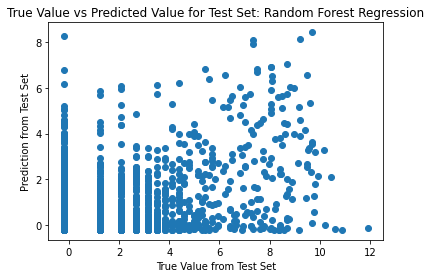

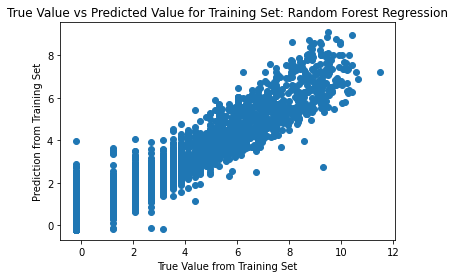

ValueError: ignored

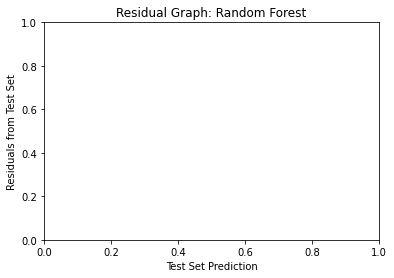

In [ ]:
run_full_random_forest_regression_with_accuracy(fire_duration_prediction_df[:SUBSET], log_fire_duration[:SUBSET])

## Random Forest Regression FIRE_SIZE

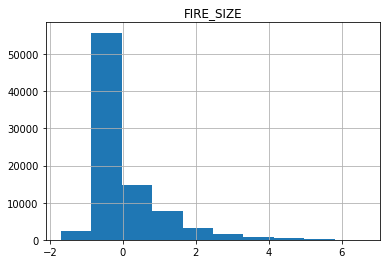

Response Minimum: FIRE_SIZE   -1.698422
dtype: float64
Response Maximum: FIRE_SIZE    6.638909
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


KeyboardInterrupt: ignored

In [ ]:
log_fire_size = pd.DataFrame(np.log(FIRE_SIZE))
log_fire_size = log_fire_size.replace([np.inf, -np.inf], np.nan)
log_fire_size = log_fire_size.fillna(0)
log_fire_size = (log_fire_size - log_fire_size.mean()) / log_fire_size.std()
log_fire_size.hist()
plt.show()

# run_full_SVM_regression_with_accuracy(fire_size_prediction_df[:SUBSET], log_fire_size[:SUBSET])
run_full_random_forest_regression_with_accuracy(fire_size_prediction_df[:-1], log_fire_size[:-1])


Response Minimum: FIRE_SIZE   -1.698422
dtype: float64
Response Maximum: FIRE_SIZE    6.638909
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training: mean absolute error:  0.25446062326206703
Test mean absolute error:  0.6681863760662583
Training average error rate:  0.1714524020813536
Test average error rate:  0.4603202742169611
Explained variance in training set is:  0.8693374232241285
Explained variance in test set is:  0.14721311827405048


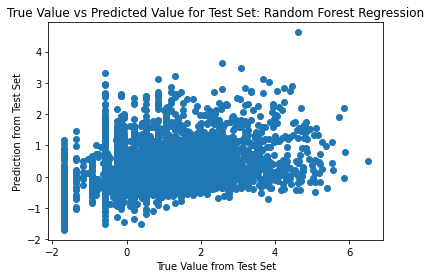

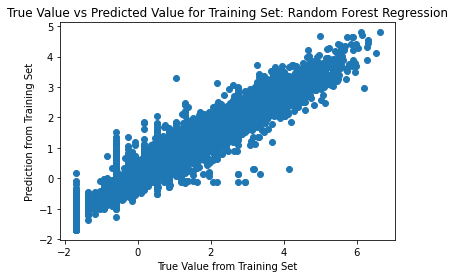

In [ ]:
# Random forests for summer months
run_full_random_forest_regression_with_accuracy(summer_fires_df, summer_fires_log_size)

# Model 2: Random Forest Classifier

In [ ]:
# Model 2: 
stat = numerical['STAT_CAUSE_CODE']
stat.value_counts()

cleaned_stat1 = numerical[numerical.STAT_CAUSE_CODE != 13.0]
cleaned_stat = cleaned_stat1[cleaned_stat1.STAT_CAUSE_CODE != 9.0]

col_index = cleaned_stat.columns.get_loc('STAT_CAUSE_CODE')
#print(col_index)
cleaned_stat.head()

# use either a random forest or neural network to predict the 

,Unnamed: 0,BODIE,BROOKS,COHASSET,CONTAINMENT_MONTH,CONT_DATE,CONT_DOY,CONT_TIME,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_MONTH,DISCOVERY_TIME,EEL_RIVER,FIRE_SIZE,FIRE_YEAR,FOD_ID,HELL_HOLE,HERNANDEZ,HUNTER_MOUNTAIN,JUANITA_LAKE,LADDER_BUTTE,LAS_TABLAS,LA_HONDA,OAK_CREEK,PANAMINT,PILOT_HILL,PRIMARY_STATION_10_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_10_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_10_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_10_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_10_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_10_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_11_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,...,PRIMARY_STATION_7_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_7_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_8_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_8_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_8_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_9_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_9_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_9_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_9_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_9_MONTHS_PRIOR_TEMPERATURE_MIN,SCORPION,SOLDIER_MOUNTAIN,SQUAW_LAKE,STAMPEDE,STAT_CAUSE_CODE,Unnamed: 0.1,VAN_BREMMER,WOLVERTON,S_LATITUDE,S_LONGITUDE,PRIMARY_STATION_ELEVATION,DURATION
1,1,-1.237103,-0.939629,-0.802799,5,2453137.5,133.0,1530.0,2453137.5,133,5,845.0,-0.597768,0.25,2004,2,-1.471873,-0.562875,-0.243079,-0.487813,-0.669480,-0.281374,-0.869095,-0.451833,-0.057172,-1.280961,1.107121,1.246597,-1.892349,1.462712,0.616480,-1.143144,1.346270,1.326651,-0.155696,-0.935826,1.266014,1.148791,1.326016,0.515265,...,0.364579,0.480207,0.712551,0.843521,-1.088438,1.228810,0.887540,-1.045693,1.184631,0.899683,-0.155696,-0.935826,1.008103,0.901795,1.079010,0.449504,1.179417,-1.346469,1.000752,0.740623,-1.080272,1.184631,-0.641117,-0.155696,-0.935826,0.882632,0.765948,0.959249,-0.473194,-0.612901,0.315528,-1.287797,1.0,1,-0.513504,-0.311271,0.672217,0.388850,0.525056,0.0
2,2,-1.070104,-1.059637,-0.891098,6,2453156.5,152.0,2024.0,2453156.5,152,6,1921.0,-0.695749,0.10,2004,3,-1.410920,-0.543260,-0.109734,-0.533929,-0.714976,-0.262071,-0.950563,-0.317057,0.059122,-1.392229,

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 135 decision trees (figured out in the next few blocks of code that this is optimal)
forest = RandomForestClassifier(n_estimators = 135, oob_score = True)

In [ ]:
x_train_mod2 = np.array(cleaned_stat.iloc[:, col_index+1:])
y_mod2 = cleaned_stat.iloc[:, [col_index]]
y_train_mod2 = np.array(y_mod2)

forest.fit(x_train_mod2, y_train_mod2.ravel())
print(forest.score(x_train_mod2, y_train_mod2))
print(forest.oob_score_)

1.0
0.6247818786422151


curr estimators: 20


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


curr estimators: 22


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


curr estimators: 24


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


curr estimators: 26
curr estimators: 28


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


curr estimators: 30
curr estimators: 32
curr estimators: 34
curr estimators: 36
curr estimators: 38
curr estimators: 40
curr estimators: 42
curr estimators: 44
curr estimators: 46
curr estimators: 48
curr estimators: 50
curr estimators: 52
curr estimators: 54
curr estimators: 56
curr estimators: 58
curr estimators: 60
curr estimators: 62
curr estimators: 64
curr estimators: 66
curr estimators: 68
curr estimators: 70
curr estimators: 72
curr estimators: 74
curr estimators: 76
curr estimators: 78
curr estimators: 80
curr estimators: 82
curr estimators: 84
curr estimators: 86
curr estimators: 88
curr estimators: 90
curr estimators: 92
curr estimators: 94
curr estimators: 96
curr estimators: 98


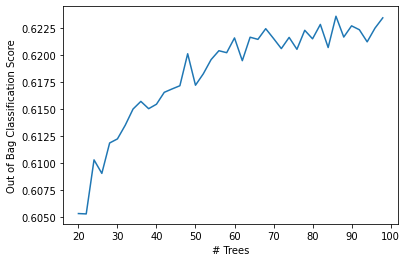

In [ ]:
oob_list = []

for i in range(20, 100, 2):
    print("curr estimators:", i)
    forest = RandomForestClassifier(n_estimators = i, oob_score = True)
    forest.fit(x_train_mod2, y_train_mod2.ravel())
    oob_list.append(forest.oob_score_)
plt.plot(list(range(20, 100, 2)), oob_list)
plt.xlabel('# Trees')
plt.ylabel('Out of Bag Classification Score')
plt.show()

curr estimators: 100
curr estimators: 102
curr estimators: 104
curr estimators: 106
curr estimators: 108
curr estimators: 110
curr estimators: 112
curr estimators: 114
curr estimators: 116
curr estimators: 118
curr estimators: 120
curr estimators: 122
curr estimators: 124
curr estimators: 126
curr estimators: 128
curr estimators: 130
curr estimators: 132
curr estimators: 134
curr estimators: 136
curr estimators: 138
curr estimators: 140
curr estimators: 142
curr estimators: 144
curr estimators: 146
curr estimators: 148


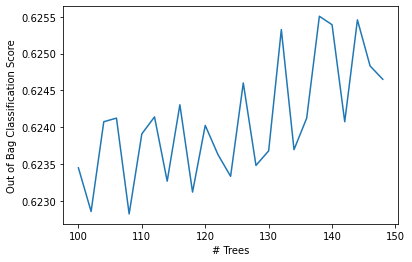

In [ ]:
oob_list2 = []

for i in range(100, 150, 2):
    print("curr estimators:", i)
    forest = RandomForestClassifier(n_estimators = i, oob_score = True)
    forest.fit(x_train_mod2, y_train_mod2.ravel())
    oob_list2.append(forest.oob_score_)
plt.plot(list(range(100, 150, 2)), oob_list2)
plt.xlabel('# Trees')
plt.ylabel('Out of Bag Classification Score')
plt.show()

curr estimators: 150
curr estimators: 152
curr estimators: 154
curr estimators: 156
curr estimators: 158
curr estimators: 160
curr estimators: 162
curr estimators: 164
curr estimators: 166
curr estimators: 168
curr estimators: 170
curr estimators: 172
curr estimators: 174
curr estimators: 176
curr estimators: 178
curr estimators: 180
curr estimators: 182
curr estimators: 184
curr estimators: 186
curr estimators: 188
curr estimators: 190
curr estimators: 192
curr estimators: 194
curr estimators: 196
curr estimators: 198


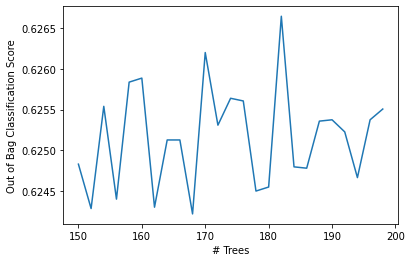

In [ ]:
oob_list3 = []

for i in range(150, 200, 2):
    print("curr estimators:", i)
    forest = RandomForestClassifier(n_estimators = i, oob_score = True)
    forest.fit(x_train_mod2, y_train_mod2.ravel())
    oob_list3.append(forest.oob_score_)
plt.plot(list(range(150, 200, 2)), oob_list3)
plt.xlabel('# Trees')
plt.ylabel('Out of Bag Classification Score')
plt.show()

In [ ]:
forest = RandomForestClassifier(n_estimators = 182, oob_score = True)
forest.fit(x_train_mod2, y_train_mod2.ravel())
val_list = forest.feature_importances_
idx_list = np.argsort(val_list)[::-1]

print('From high to low:')
for idx in idx_list:
    print('Feature %d: %f' % (idx, val_list[idx]))

From high to low:
Feature 0: 0.215777
Feature 4: 0.187571
Feature 3: 0.174209
Feature 1: 0.166072
Feature 2: 0.162683
Feature 5: 0.050670
Feature 6: 0.043017


In [ ]:
x_train_mod3 = np.array(cleaned_stat.iloc[:, col_index+1:])
y_mod3 = cleaned_stat.iloc[:, [col_index]]
y_train_mod3 = np.array(y_mod3)

forest.fit(x_train_mod3, y_train_mod3.ravel())
print(forest.score(x_train_mod3, y_train_mod3))
print(forest.oob_score_)

1.0
0.6264445395581603


In [ ]:
forest = RandomForestClassifier(n_estimators = 182, oob_score = True)

x_train_mod2 = np.array(cleaned_stat.iloc[:, col_index+1:])
y_mod2 = cleaned_stat.iloc[:, [col_index]]
y_train_mod2 = np.array(y_mod2)

X_train, X_test, y_train, y_test = train_test_split(cleaned_stat, y_train_mod2, test_size=0.2, random_state=2020)

forest.fit(X_train, y_train.ravel())
print(forest.score(X_test, y_test))
print(forest.oob_score_)



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


0.8585185185185186
0.8519837023623343
